# Vector Quantization Layer Experiments

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
K = 5        # num embeddings
BETA = 0.25   # weighting parameter for the commitment loss

In [3]:
def vq_layer(x: tf.Tensor, embed_space: tf.Tensor = None) -> tf.Tensor:
    # x has shape [BATCH_SIZE, dim]
    dim = x.shape[1]
    if not embed_space:
        embed_space = tf.get_variable("embed_space", shape=(K, dim), dtype=tf.float32)
    
    print(x.shape)
    scores = tf.reduce_sum(tf.square(tf.expand_dims(x, 2) - tf.transpose(embed_space)), axis=1)  # shape [BATCH_SIZE, K]
    print(scores.shape)
    closest = tf.argmin(scores, axis=1)  # shape [BATCH_SIZE,]
    print(closest.shape)
    
    chosen_embeddings = tf.gather(embed_space, indices=closest, axis=0)
    print(chosen_embeddings.shape)  # shape [BATCH_SIZE, dim]
    
    # this loss moves the embeddings closer to the actual input
    vq_loss = tf.reduce_mean(tf.norm(tf.stop_gradient(x) - chosen_embeddings, ord='euclidean'))
    tf.add_to_collection(tf.GraphKeys.LOSSES, vq_loss)
    
    # this loss makes sure the embedding space keeps 'relevant'
    commit_loss = BETA * tf.reduce_mean(tf.norm(x - tf.stop_gradient(chosen_embeddings), ord='euclidean'))
    tf.add_to_collection(tf.GraphKeys.LOSSES, commit_loss)
    
    return tf.stop_gradient(chosen_embeddings - x) + x   # don't propagate gradients into the embeddings here

In [4]:
tf.reset_default_graph()
dim = 3

np.random.seed(1234)
embed_space = np.random.rand(K, dim)
test_embed_space = tf.get_variable("test_embed_space", shape=embed_space.shape,dtype=tf.float32,
                                   initializer=tf.constant_initializer(embed_space))

x = tf.placeholder(shape=(None, dim), dtype=tf.float32)
labels = tf.placeholder(shape=(None), dtype=tf.uint8)

net = tf.layers.dense(x, units=dim, name="hidden-1")
net = vq_layer(net, embed_space=test_embed_space)
logits = tf.layers.dense(net, units=dim, name="hidden-2")

(?, 3)
(?, 5)
(?,)
(?, 3)


In [5]:
# example training data
train_data = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]], dtype=np.float32)
train_labels = np.array([0, 1, 2], dtype=np.uint8)

In [6]:
# data loss
one_hot_labels = tf.one_hot(labels, depth=dim)
data_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
data_loss = tf.reduce_mean(data_loss)
tf.add_to_collection(tf.GraphKeys.LOSSES, data_loss)

In [7]:
# trainer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
all_losses = tf.add_n(tf.get_collection(tf.GraphKeys.LOSSES))
train_op = optimizer.minimize(all_losses)

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()

NUM_EPOCHS = 10000
NUM_EXAMPLES = train_data.shape[0]

losses = []

with sess.as_default():
    sess.run(init)
    
    print("Initial embedding space:")
    initial_space = sess.run(test_embed_space)
    print(initial_space)
    
    for i in range(NUM_EPOCHS):
        print("Starting epoch #{}".format(i + 1))
        
        _, loss = sess.run([train_op, all_losses], feed_dict={x: train_data, labels: train_labels})
        print("-- loss: {}".format(loss))
        losses.append(loss)
        
    print("Embedding space after {} epochs:".format(NUM_EPOCHS))
    final_space = sess.run(test_embed_space)
    print(final_space)

Initial embedding space:
[[0.19151945 0.62210876 0.43772775]
 [0.7853586  0.77997583 0.2725926 ]
 [0.27646425 0.8018722  0.95813936]
 [0.87593263 0.35781726 0.5009951 ]
 [0.6834629  0.71270204 0.37025076]]
Starting epoch #1
-- loss: 4.185966968536377
Starting epoch #2
-- loss: 4.1834492683410645
Starting epoch #3
-- loss: 4.180934906005859
Starting epoch #4
-- loss: 4.17842435836792
Starting epoch #5
-- loss: 4.175917148590088
Starting epoch #6
-- loss: 4.1734137535095215
Starting epoch #7
-- loss: 4.1709136962890625
Starting epoch #8
-- loss: 4.168417453765869
Starting epoch #9
-- loss: 4.165925025939941
Starting epoch #10
-- loss: 4.163435459136963
Starting epoch #11
-- loss: 4.16094970703125
Starting epoch #12
-- loss: 4.158467769622803
Starting epoch #13
-- loss: 4.155989170074463
Starting epoch #14
-- loss: 4.1535139083862305
Starting epoch #15
-- loss: 4.151042938232422
Starting epoch #16
-- loss: 4.148575305938721
Starting epoch #17
-- loss: 4.146111011505127
Starting epoch #18


-- loss: 3.663412570953369
Starting epoch #257
-- loss: 3.6618409156799316
Starting epoch #258
-- loss: 3.6602730751037598
Starting epoch #259
-- loss: 3.6587085723876953
Starting epoch #260
-- loss: 3.6571483612060547
Starting epoch #261
-- loss: 3.6555910110473633
Starting epoch #262
-- loss: 3.654038190841675
Starting epoch #263
-- loss: 3.6524887084960938
Starting epoch #264
-- loss: 3.650942325592041
Starting epoch #265
-- loss: 3.649400234222412
Starting epoch #266
-- loss: 3.6478614807128906
Starting epoch #267
-- loss: 3.6463265419006348
Starting epoch #268
-- loss: 3.6447949409484863
Starting epoch #269
-- loss: 3.6432671546936035
Starting epoch #270
-- loss: 3.6417436599731445
Starting epoch #271
-- loss: 3.6402230262756348
Starting epoch #272
-- loss: 3.6387062072753906
Starting epoch #273
-- loss: 3.637192726135254
Starting epoch #274
-- loss: 3.635683059692383
Starting epoch #275
-- loss: 3.6341772079467773
Starting epoch #276
-- loss: 3.6326749324798584
Starting epoch #27

-- loss: 3.3123960494995117
Starting epoch #601
-- loss: 3.3118302822113037
Starting epoch #602
-- loss: 3.3112664222717285
Starting epoch #603
-- loss: 3.310704231262207
Starting epoch #604
-- loss: 3.3101441860198975
Starting epoch #605
-- loss: 3.309586524963379
Starting epoch #606
-- loss: 3.309030532836914
Starting epoch #607
-- loss: 3.308476448059082
Starting epoch #608
-- loss: 3.307924270629883
Starting epoch #609
-- loss: 3.3073740005493164
Starting epoch #610
-- loss: 3.306826114654541
Starting epoch #611
-- loss: 3.3062798976898193
Starting epoch #612
-- loss: 3.3057355880737305
Starting epoch #613
-- loss: 3.3051929473876953
Starting epoch #614
-- loss: 3.304652690887451
Starting epoch #615
-- loss: 3.30411434173584
Starting epoch #616
-- loss: 3.303577423095703
Starting epoch #617
-- loss: 3.3030428886413574
Starting epoch #618
-- loss: 3.3025102615356445
Starting epoch #619
-- loss: 3.3019790649414062
Starting epoch #620
-- loss: 3.301450252532959
Starting epoch #621
-- 

-- loss: 3.1999688148498535
Starting epoch #969
-- loss: 3.1998400688171387
Starting epoch #970
-- loss: 3.199711322784424
Starting epoch #971
-- loss: 3.1995832920074463
Starting epoch #972
-- loss: 3.199456214904785
Starting epoch #973
-- loss: 3.199329137802124
Starting epoch #974
-- loss: 3.1992034912109375
Starting epoch #975
-- loss: 3.199077606201172
Starting epoch #976
-- loss: 3.1989526748657227
Starting epoch #977
-- loss: 3.1988277435302734
Starting epoch #978
-- loss: 3.198704242706299
Starting epoch #979
-- loss: 3.1985812187194824
Starting epoch #980
-- loss: 3.198458671569824
Starting epoch #981
-- loss: 3.198336124420166
Starting epoch #982
-- loss: 3.1982150077819824
Starting epoch #983
-- loss: 3.198093891143799
Starting epoch #984
-- loss: 3.1979737281799316
Starting epoch #985
-- loss: 3.1978540420532227
Starting epoch #986
-- loss: 3.1977345943450928
Starting epoch #987
-- loss: 3.1976161003112793
Starting epoch #988
-- loss: 3.197497844696045
Starting epoch #989
-

-- loss: 3.180807590484619
Starting epoch #1337
-- loss: 3.180809259414673
Starting epoch #1338
-- loss: 3.1808111667633057
Starting epoch #1339
-- loss: 3.1808133125305176
Starting epoch #1340
-- loss: 3.1808152198791504
Starting epoch #1341
-- loss: 3.1808176040649414
Starting epoch #1342
-- loss: 3.1808204650878906
Starting epoch #1343
-- loss: 3.1808228492736816
Starting epoch #1344
-- loss: 3.180826187133789
Starting epoch #1345
-- loss: 3.1808290481567383
Starting epoch #1346
-- loss: 3.180832862854004
Starting epoch #1347
-- loss: 3.1808359622955322
Starting epoch #1348
-- loss: 3.180840015411377
Starting epoch #1349
-- loss: 3.1808438301086426
Starting epoch #1350
-- loss: 3.1808481216430664
Starting epoch #1351
-- loss: 3.1808524131774902
Starting epoch #1352
-- loss: 3.1808571815490723
Starting epoch #1353
-- loss: 3.180861473083496
Starting epoch #1354
-- loss: 3.1808667182922363
Starting epoch #1355
-- loss: 3.1808714866638184
Starting epoch #1356
-- loss: 3.180876970291137

-- loss: 3.1911673545837402
Starting epoch #1685
-- loss: 3.191220760345459
Starting epoch #1686
-- loss: 3.1912736892700195
Starting epoch #1687
-- loss: 3.1913275718688965
Starting epoch #1688
-- loss: 3.191380739212036
Starting epoch #1689
-- loss: 3.191434860229492
Starting epoch #1690
-- loss: 3.191488265991211
Starting epoch #1691
-- loss: 3.191542148590088
Starting epoch #1692
-- loss: 3.191596031188965
Starting epoch #1693
-- loss: 3.191650390625
Starting epoch #1694
-- loss: 3.191704273223877
Starting epoch #1695
-- loss: 3.191758632659912
Starting epoch #1696
-- loss: 3.1918129920959473
Starting epoch #1697
-- loss: 3.1918675899505615
Starting epoch #1698
-- loss: 3.191922187805176
Starting epoch #1699
-- loss: 3.191977024078369
Starting epoch #1700
-- loss: 3.1920316219329834
Starting epoch #1701
-- loss: 3.192086696624756
Starting epoch #1702
-- loss: 3.1921420097351074
Starting epoch #1703
-- loss: 3.192196846008301
Starting epoch #1704
-- loss: 3.1922521591186523
Starting

-- loss: 3.2112746238708496
Starting epoch #1979
-- loss: 3.2113571166992188
Starting epoch #1980
-- loss: 3.211439609527588
Starting epoch #1981
-- loss: 3.2115225791931152
Starting epoch #1982
-- loss: 3.2116053104400635
Starting epoch #1983
-- loss: 3.2116880416870117
Starting epoch #1984
-- loss: 3.211771011352539
Starting epoch #1985
-- loss: 3.2118539810180664
Starting epoch #1986
-- loss: 3.211937427520752
Starting epoch #1987
-- loss: 3.2120208740234375
Starting epoch #1988
-- loss: 3.212103843688965
Starting epoch #1989
-- loss: 3.2121872901916504
Starting epoch #1990
-- loss: 3.212271213531494
Starting epoch #1991
-- loss: 3.2123546600341797
Starting epoch #1992
-- loss: 3.2124381065368652
Starting epoch #1993
-- loss: 3.212522029876709
Starting epoch #1994
-- loss: 3.2126059532165527
Starting epoch #1995
-- loss: 3.2126898765563965
Starting epoch #1996
-- loss: 3.2127742767333984
Starting epoch #1997
-- loss: 3.212858200073242
Starting epoch #1998
-- loss: 3.212942600250244


-- loss: 3.2461953163146973
Starting epoch #2337
-- loss: 3.246307134628296
Starting epoch #2338
-- loss: 3.2464189529418945
Starting epoch #2339
-- loss: 3.2465310096740723
Starting epoch #2340
-- loss: 3.24664306640625
Starting epoch #2341
-- loss: 3.2467546463012695
Starting epoch #2342
-- loss: 3.2468667030334473
Starting epoch #2343
-- loss: 3.246978998184204
Starting epoch #2344
-- loss: 3.247091293334961
Starting epoch #2345
-- loss: 3.247203826904297
Starting epoch #2346
-- loss: 3.2473156452178955
Starting epoch #2347
-- loss: 3.2474284172058105
Starting epoch #2348
-- loss: 3.2475404739379883
Starting epoch #2349
-- loss: 3.247653007507324
Starting epoch #2350
-- loss: 3.24776554107666
Starting epoch #2351
-- loss: 3.2478785514831543
Starting epoch #2352
-- loss: 3.2479915618896484
Starting epoch #2353
-- loss: 3.2481040954589844
Starting epoch #2354
-- loss: 3.2482171058654785
Starting epoch #2355
-- loss: 3.2483301162719727
Starting epoch #2356
-- loss: 3.248443365097046
St

-- loss: 3.290931224822998
Starting epoch #2697
-- loss: 3.291067123413086
Starting epoch #2698
-- loss: 3.291203498840332
Starting epoch #2699
-- loss: 3.291339874267578
Starting epoch #2700
-- loss: 3.291476249694824
Starting epoch #2701
-- loss: 3.2916126251220703
Starting epoch #2702
-- loss: 3.2917490005493164
Starting epoch #2703
-- loss: 3.2918858528137207
Starting epoch #2704
-- loss: 3.292022228240967
Starting epoch #2705
-- loss: 3.29215931892395
Starting epoch #2706
-- loss: 3.2922959327697754
Starting epoch #2707
-- loss: 3.2924327850341797
Starting epoch #2708
-- loss: 3.292569160461426
Starting epoch #2709
-- loss: 3.2927064895629883
Starting epoch #2710
-- loss: 3.2928435802459717
Starting epoch #2711
-- loss: 3.292980670928955
Starting epoch #2712
-- loss: 3.2931175231933594
Starting epoch #2713
-- loss: 3.293255090713501
Starting epoch #2714
-- loss: 3.2933921813964844
Starting epoch #2715
-- loss: 3.293529748916626
Starting epoch #2716
-- loss: 3.2936670780181885
Star

-- loss: 2.86381459236145
Starting epoch #3055
-- loss: 2.8622751235961914
Starting epoch #3056
-- loss: 2.8607370853424072
Starting epoch #3057
-- loss: 2.8592004776000977
Starting epoch #3058
-- loss: 2.8576648235321045
Starting epoch #3059
-- loss: 2.856130599975586
Starting epoch #3060
-- loss: 2.854598045349121
Starting epoch #3061
-- loss: 2.8530664443969727
Starting epoch #3062
-- loss: 2.851536273956299
Starting epoch #3063
-- loss: 2.8500075340270996
Starting epoch #3064
-- loss: 2.848479747772217
Starting epoch #3065
-- loss: 2.846953868865967
Starting epoch #3066
-- loss: 2.845428705215454
Starting epoch #3067
-- loss: 2.843904972076416
Starting epoch #3068
-- loss: 2.8423826694488525
Starting epoch #3069
-- loss: 2.8408620357513428
Starting epoch #3070
-- loss: 2.8393423557281494
Starting epoch #3071
-- loss: 2.8378241062164307
Starting epoch #3072
-- loss: 2.8363070487976074
Starting epoch #3073
-- loss: 2.834791421890259
Starting epoch #3074
-- loss: 2.8332772254943848
St

-- loss: 2.407804012298584
Starting epoch #3409
-- loss: 2.4067835807800293
Starting epoch #3410
-- loss: 2.4057650566101074
Starting epoch #3411
-- loss: 2.40474796295166
Starting epoch #3412
-- loss: 2.4037325382232666
Starting epoch #3413
-- loss: 2.4027185440063477
Starting epoch #3414
-- loss: 2.4017059803009033
Starting epoch #3415
-- loss: 2.4006950855255127
Starting epoch #3416
-- loss: 2.399685859680176
Starting epoch #3417
-- loss: 2.3986783027648926
Starting epoch #3418
-- loss: 2.397671937942505
Starting epoch #3419
-- loss: 2.396667242050171
Starting epoch #3420
-- loss: 2.3956642150878906
Starting epoch #3421
-- loss: 2.394662857055664
Starting epoch #3422
-- loss: 2.393662691116333
Starting epoch #3423
-- loss: 2.3926644325256348
Starting epoch #3424
-- loss: 2.391667366027832
Starting epoch #3425
-- loss: 2.390672206878662
Starting epoch #3426
-- loss: 2.389678478240967
Starting epoch #3427
-- loss: 2.388686418533325
Starting epoch #3428
-- loss: 2.387695789337158
Start

Starting epoch #3765
-- loss: 2.1383020877838135
Starting epoch #3766
-- loss: 2.137791872024536
Starting epoch #3767
-- loss: 2.1372828483581543
Starting epoch #3768
-- loss: 2.136775016784668
Starting epoch #3769
-- loss: 2.1362686157226562
Starting epoch #3770
-- loss: 2.135763168334961
Starting epoch #3771
-- loss: 2.135258674621582
Starting epoch #3772
-- loss: 2.134755849838257
Starting epoch #3773
-- loss: 2.134253978729248
Starting epoch #3774
-- loss: 2.1337532997131348
Starting epoch #3775
-- loss: 2.133253574371338
Starting epoch #3776
-- loss: 2.1327552795410156
Starting epoch #3777
-- loss: 2.132258415222168
Starting epoch #3778
-- loss: 2.1317622661590576
Starting epoch #3779
-- loss: 2.1312673091888428
Starting epoch #3780
-- loss: 2.1307737827301025
Starting epoch #3781
-- loss: 2.1302812099456787
Starting epoch #3782
-- loss: 2.1297900676727295
Starting epoch #3783
-- loss: 2.1292996406555176
Starting epoch #3784
-- loss: 2.1288108825683594
Starting epoch #3785
-- loss

-- loss: 2.0174944400787354
Starting epoch #4128
-- loss: 2.0172998905181885
Starting epoch #4129
-- loss: 2.017106056213379
Starting epoch #4130
-- loss: 2.0169124603271484
Starting epoch #4131
-- loss: 2.0167195796966553
Starting epoch #4132
-- loss: 2.0165271759033203
Starting epoch #4133
-- loss: 2.0163354873657227
Starting epoch #4134
-- loss: 2.016144275665283
Starting epoch #4135
-- loss: 2.015953540802002
Starting epoch #4136
-- loss: 2.015763759613037
Starting epoch #4137
-- loss: 2.0155744552612305
Starting epoch #4138
-- loss: 2.015385389328003
Starting epoch #4139
-- loss: 2.0151970386505127
Starting epoch #4140
-- loss: 2.0150091648101807
Starting epoch #4141
-- loss: 2.014822006225586
Starting epoch #4142
-- loss: 2.0146353244781494
Starting epoch #4143
-- loss: 2.014449119567871
Starting epoch #4144
-- loss: 2.01426362991333
Starting epoch #4145
-- loss: 2.014078378677368
Starting epoch #4146
-- loss: 2.0138938426971436
Starting epoch #4147
-- loss: 2.0137100219726562
St

-- loss: 1.974428653717041
Starting epoch #4501
-- loss: 1.9743704795837402
Starting epoch #4502
-- loss: 1.9743125438690186
Starting epoch #4503
-- loss: 1.9742546081542969
Starting epoch #4504
-- loss: 1.9741969108581543
Starting epoch #4505
-- loss: 1.97413969039917
Starting epoch #4506
-- loss: 1.974082589149475
Starting epoch #4507
-- loss: 1.9740257263183594
Starting epoch #4508
-- loss: 1.9739689826965332
Starting epoch #4509
-- loss: 1.9739124774932861
Starting epoch #4510
-- loss: 1.9738562107086182
Starting epoch #4511
-- loss: 1.9738001823425293
Starting epoch #4512
-- loss: 1.9737441539764404
Starting epoch #4513
-- loss: 1.9736883640289307
Starting epoch #4514
-- loss: 1.9736328125
Starting epoch #4515
-- loss: 1.9735777378082275
Starting epoch #4516
-- loss: 1.973522663116455
Starting epoch #4517
-- loss: 1.9734675884246826
Starting epoch #4518
-- loss: 1.9734129905700684
Starting epoch #4519
-- loss: 1.9733586311340332
Starting epoch #4520
-- loss: 1.973304271697998
Star

-- loss: 1.9635837078094482
Starting epoch #4867
-- loss: 1.9635746479034424
Starting epoch #4868
-- loss: 1.9635660648345947
Starting epoch #4869
-- loss: 1.963557481765747
Starting epoch #4870
-- loss: 1.9635486602783203
Starting epoch #4871
-- loss: 1.9635405540466309
Starting epoch #4872
-- loss: 1.963531732559204
Starting epoch #4873
-- loss: 1.9635236263275146
Starting epoch #4874
-- loss: 1.963515281677246
Starting epoch #4875
-- loss: 1.9635071754455566
Starting epoch #4876
-- loss: 1.9634993076324463
Starting epoch #4877
-- loss: 1.963491439819336
Starting epoch #4878
-- loss: 1.963483214378357
Starting epoch #4879
-- loss: 1.9634753465652466
Starting epoch #4880
-- loss: 1.9634675979614258
Starting epoch #4881
-- loss: 1.9634599685668945
Starting epoch #4882
-- loss: 1.9634523391723633
Starting epoch #4883
-- loss: 1.9634449481964111
Starting epoch #4884
-- loss: 1.9634373188018799
Starting epoch #4885
-- loss: 1.9634300470352173
Starting epoch #4886
-- loss: 1.96342277526855

-- loss: 1.9644949436187744
Starting epoch #5233
-- loss: 1.9645061492919922
Starting epoch #5234
-- loss: 1.96451735496521
Starting epoch #5235
-- loss: 1.9645285606384277
Starting epoch #5236
-- loss: 1.9645400047302246
Starting epoch #5237
-- loss: 1.9645510911941528
Starting epoch #5238
-- loss: 1.9645626544952393
Starting epoch #5239
-- loss: 1.9645739793777466
Starting epoch #5240
-- loss: 1.9645854234695435
Starting epoch #5241
-- loss: 1.9645967483520508
Starting epoch #5242
-- loss: 1.9646081924438477
Starting epoch #5243
-- loss: 1.9646196365356445
Starting epoch #5244
-- loss: 1.9646313190460205
Starting epoch #5245
-- loss: 1.964642882347107
Starting epoch #5246
-- loss: 1.9646546840667725
Starting epoch #5247
-- loss: 1.9646661281585693
Starting epoch #5248
-- loss: 1.9646778106689453
Starting epoch #5249
-- loss: 1.9646896123886108
Starting epoch #5250
-- loss: 1.9647011756896973
Starting epoch #5251
-- loss: 1.9647130966186523
Starting epoch #5252
-- loss: 1.964724779129

-- loss: 1.9698020219802856
Starting epoch #5563
-- loss: 1.9698224067687988
Starting epoch #5564
-- loss: 1.9698424339294434
Starting epoch #5565
-- loss: 1.969862699508667
Starting epoch #5566
-- loss: 1.9698829650878906
Starting epoch #5567
-- loss: 1.9699034690856934
Starting epoch #5568
-- loss: 1.969923973083496
Starting epoch #5569
-- loss: 1.9699442386627197
Starting epoch #5570
-- loss: 1.9699647426605225
Starting epoch #5571
-- loss: 1.969984769821167
Starting epoch #5572
-- loss: 1.9700055122375488
Starting epoch #5573
-- loss: 1.9700257778167725
Starting epoch #5574
-- loss: 1.970046043395996
Starting epoch #5575
-- loss: 1.970066785812378
Starting epoch #5576
-- loss: 1.9700872898101807
Starting epoch #5577
-- loss: 1.9701077938079834
Starting epoch #5578
-- loss: 1.9701282978057861
Starting epoch #5579
-- loss: 1.9701488018035889
Starting epoch #5580
-- loss: 1.9701695442199707
Starting epoch #5581
-- loss: 1.9701900482177734
Starting epoch #5582
-- loss: 1.97021055221557

-- loss: 1.9769902229309082
Starting epoch #5874
-- loss: 1.9770159721374512
Starting epoch #5875
-- loss: 1.9770417213439941
Starting epoch #5876
-- loss: 1.9770673513412476
Starting epoch #5877
-- loss: 1.977092981338501
Starting epoch #5878
-- loss: 1.977118730545044
Starting epoch #5879
-- loss: 1.977144479751587
Starting epoch #5880
-- loss: 1.977170467376709
Starting epoch #5881
-- loss: 1.977196216583252
Starting epoch #5882
-- loss: 1.977221965789795
Starting epoch #5883
-- loss: 1.977247714996338
Starting epoch #5884
-- loss: 1.9772734642028809
Starting epoch #5885
-- loss: 1.977299451828003
Starting epoch #5886
-- loss: 1.977325201034546
Starting epoch #5887
-- loss: 1.977351188659668
Starting epoch #5888
-- loss: 1.977376937866211
Starting epoch #5889
-- loss: 1.977402925491333
Starting epoch #5890
-- loss: 1.977428913116455
Starting epoch #5891
-- loss: 1.977454662322998
Starting epoch #5892
-- loss: 1.9774806499481201
Starting epoch #5893
-- loss: 1.9775066375732422
Starti

-- loss: 1.987229347229004
Starting epoch #6238
-- loss: 1.9872596263885498
Starting epoch #6239
-- loss: 1.9872901439666748
Starting epoch #6240
-- loss: 1.9873206615447998
Starting epoch #6241
-- loss: 1.9873509407043457
Starting epoch #6242
-- loss: 1.9873814582824707
Starting epoch #6243
-- loss: 1.9874118566513062
Starting epoch #6244
-- loss: 1.9874424934387207
Starting epoch #6245
-- loss: 1.9874727725982666
Starting epoch #6246
-- loss: 1.987503170967102
Starting epoch #6247
-- loss: 1.9875338077545166
Starting epoch #6248
-- loss: 1.987563967704773
Starting epoch #6249
-- loss: 1.9875946044921875
Starting epoch #6250
-- loss: 1.9876251220703125
Starting epoch #6251
-- loss: 1.9876556396484375
Starting epoch #6252
-- loss: 1.987686038017273
Starting epoch #6253
-- loss: 1.9877166748046875
Starting epoch #6254
-- loss: 1.9877471923828125
Starting epoch #6255
-- loss: 1.987777829170227
Starting epoch #6256
-- loss: 1.987808346748352
Starting epoch #6257
-- loss: 1.987838983535766

-- loss: 1.998858094215393
Starting epoch #6599
-- loss: 1.998892068862915
Starting epoch #6600
-- loss: 1.9989261627197266
Starting epoch #6601
-- loss: 1.998960018157959
Starting epoch #6602
-- loss: 1.998993992805481
Starting epoch #6603
-- loss: 1.999027967453003
Starting epoch #6604
-- loss: 1.9990620613098145
Starting epoch #6605
-- loss: 1.9990959167480469
Starting epoch #6606
-- loss: 1.999130129814148
Starting epoch #6607
-- loss: 1.99916410446167
Starting epoch #6608
-- loss: 1.9991981983184814
Starting epoch #6609
-- loss: 1.999232292175293
Starting epoch #6610
-- loss: 1.999266266822815
Starting epoch #6611
-- loss: 1.999300241470337
Starting epoch #6612
-- loss: 1.9993343353271484
Starting epoch #6613
-- loss: 1.999368667602539
Starting epoch #6614
-- loss: 1.999402642250061
Starting epoch #6615
-- loss: 1.999436855316162
Starting epoch #6616
-- loss: 1.9994707107543945
Starting epoch #6617
-- loss: 1.999504804611206
Starting epoch #6618
-- loss: 1.9995388984680176
Startin

-- loss: 2.0116257667541504
Starting epoch #6959
-- loss: 2.011662244796753
Starting epoch #6960
-- loss: 2.0116991996765137
Starting epoch #6961
-- loss: 2.0117361545562744
Starting epoch #6962
-- loss: 2.011773109436035
Starting epoch #6963
-- loss: 2.011809825897217
Starting epoch #6964
-- loss: 2.0118470191955566
Starting epoch #6965
-- loss: 2.0118837356567383
Starting epoch #6966
-- loss: 2.011920690536499
Starting epoch #6967
-- loss: 2.0119576454162598
Starting epoch #6968
-- loss: 2.0119948387145996
Starting epoch #6969
-- loss: 2.0120315551757812
Starting epoch #6970
-- loss: 2.012068510055542
Starting epoch #6971
-- loss: 2.012105703353882
Starting epoch #6972
-- loss: 2.0121426582336426
Starting epoch #6973
-- loss: 2.012179374694824
Starting epoch #6974
-- loss: 2.012216806411743
Starting epoch #6975
-- loss: 2.012253761291504
Starting epoch #6976
-- loss: 2.0122907161712646
Starting epoch #6977
-- loss: 2.0123276710510254
Starting epoch #6978
-- loss: 2.012364625930786
St

-- loss: 2.0246574878692627
Starting epoch #7301
-- loss: 2.0246968269348145
Starting epoch #7302
-- loss: 2.024735927581787
Starting epoch #7303
-- loss: 2.024775505065918
Starting epoch #7304
-- loss: 2.0248146057128906
Starting epoch #7305
-- loss: 2.0248537063598633
Starting epoch #7306
-- loss: 2.024893045425415
Starting epoch #7307
-- loss: 2.024932384490967
Starting epoch #7308
-- loss: 2.0249717235565186
Starting epoch #7309
-- loss: 2.0250113010406494
Starting epoch #7310
-- loss: 2.025050163269043
Starting epoch #7311
-- loss: 2.025089740753174
Starting epoch #7312
-- loss: 2.0251288414001465
Starting epoch #7313
-- loss: 2.0251684188842773
Starting epoch #7314
-- loss: 2.025207757949829
Starting epoch #7315
-- loss: 2.025247097015381
Starting epoch #7316
-- loss: 2.0252864360809326
Starting epoch #7317
-- loss: 2.0253257751464844
Starting epoch #7318
-- loss: 2.025365114212036
Starting epoch #7319
-- loss: 2.025404691696167
Starting epoch #7320
-- loss: 2.0254440307617188
St

-- loss: 2.0395121574401855
Starting epoch #7669
-- loss: 2.039553642272949
Starting epoch #7670
-- loss: 2.039595127105713
Starting epoch #7671
-- loss: 2.0396363735198975
Starting epoch #7672
-- loss: 2.039677858352661
Starting epoch #7673
-- loss: 2.039719343185425
Starting epoch #7674
-- loss: 2.0397605895996094
Starting epoch #7675
-- loss: 2.039802074432373
Starting epoch #7676
-- loss: 2.039843797683716
Starting epoch #7677
-- loss: 2.0398850440979004
Starting epoch #7678
-- loss: 2.039926528930664
Starting epoch #7679
-- loss: 2.0399680137634277
Starting epoch #7680
-- loss: 2.0400097370147705
Starting epoch #7681
-- loss: 2.040050983428955
Starting epoch #7682
-- loss: 2.040092706680298
Starting epoch #7683
-- loss: 2.0401339530944824
Starting epoch #7684
-- loss: 2.040175437927246
Starting epoch #7685
-- loss: 2.0402169227600098
Starting epoch #7686
-- loss: 2.0402584075927734
Starting epoch #7687
-- loss: 2.040299892425537
Starting epoch #7688
-- loss: 2.040341377258301
Star

-- loss: 2.054884672164917
Starting epoch #8032
-- loss: 2.0549278259277344
Starting epoch #8033
-- loss: 2.0549709796905518
Starting epoch #8034
-- loss: 2.0550143718719482
Starting epoch #8035
-- loss: 2.0550575256347656
Starting epoch #8036
-- loss: 2.055100679397583
Starting epoch #8037
-- loss: 2.0551440715789795
Starting epoch #8038
-- loss: 2.055187225341797
Starting epoch #8039
-- loss: 2.0552306175231934
Starting epoch #8040
-- loss: 2.0552737712860107
Starting epoch #8041
-- loss: 2.0553171634674072
Starting epoch #8042
-- loss: 2.0553605556488037
Starting epoch #8043
-- loss: 2.0554039478302
Starting epoch #8044
-- loss: 2.0554471015930176
Starting epoch #8045
-- loss: 2.055490493774414
Starting epoch #8046
-- loss: 2.0555338859558105
Starting epoch #8047
-- loss: 2.055577039718628
Starting epoch #8048
-- loss: 2.0556201934814453
Starting epoch #8049
-- loss: 2.055663585662842
Starting epoch #8050
-- loss: 2.0557069778442383
Starting epoch #8051
-- loss: 2.0557501316070557
S

-- loss: 2.070955991744995
Starting epoch #8397
-- loss: 2.071000814437866
Starting epoch #8398
-- loss: 2.071045398712158
Starting epoch #8399
-- loss: 2.0710902214050293
Starting epoch #8400
-- loss: 2.0711350440979004
Starting epoch #8401
-- loss: 2.0711798667907715
Starting epoch #8402
-- loss: 2.0712246894836426
Starting epoch #8403
-- loss: 2.0712695121765137
Starting epoch #8404
-- loss: 2.0713143348693848
Starting epoch #8405
-- loss: 2.071359157562256
Starting epoch #8406
-- loss: 2.071403980255127
Starting epoch #8407
-- loss: 2.071448802947998
Starting epoch #8408
-- loss: 2.071493625640869
Starting epoch #8409
-- loss: 2.0715384483337402
Starting epoch #8410
-- loss: 2.0715835094451904
Starting epoch #8411
-- loss: 2.0716280937194824
Starting epoch #8412
-- loss: 2.0716731548309326
Starting epoch #8413
-- loss: 2.0717179775238037
Starting epoch #8414
-- loss: 2.071762800216675
Starting epoch #8415
-- loss: 2.071807622909546
Starting epoch #8416
-- loss: 2.071852684020996
St

-- loss: 2.087599992752075
Starting epoch #8763
-- loss: 2.087646245956421
Starting epoch #8764
-- loss: 2.0876922607421875
Starting epoch #8765
-- loss: 2.087738275527954
Starting epoch #8766
-- loss: 2.0877842903137207
Starting epoch #8767
-- loss: 2.0878305435180664
Starting epoch #8768
-- loss: 2.087876796722412
Starting epoch #8769
-- loss: 2.087923049926758
Starting epoch #8770
-- loss: 2.0879693031311035
Starting epoch #8771
-- loss: 2.08801531791687
Starting epoch #8772
-- loss: 2.0880613327026367
Starting epoch #8773
-- loss: 2.0881073474884033
Starting epoch #8774
-- loss: 2.088153600692749
Starting epoch #8775
-- loss: 2.0881998538970947
Starting epoch #8776
-- loss: 2.0882458686828613
Starting epoch #8777
-- loss: 2.088292121887207
Starting epoch #8778
-- loss: 2.0883383750915527
Starting epoch #8779
-- loss: 2.0883846282958984
Starting epoch #8780
-- loss: 2.088430643081665
Starting epoch #8781
-- loss: 2.0884768962860107
Starting epoch #8782
-- loss: 2.0885231494903564
St

-- loss: 2.10290265083313
Starting epoch #9091
-- loss: 2.102950096130371
Starting epoch #9092
-- loss: 2.102997064590454
Starting epoch #9093
-- loss: 2.103044271469116
Starting epoch #9094
-- loss: 2.103091239929199
Starting epoch #9095
-- loss: 2.1031384468078613
Starting epoch #9096
-- loss: 2.1031856536865234
Starting epoch #9097
-- loss: 2.1032330989837646
Starting epoch #9098
-- loss: 2.1032800674438477
Starting epoch #9099
-- loss: 2.1033272743225098
Starting epoch #9100
-- loss: 2.103374481201172
Starting epoch #9101
-- loss: 2.103421688079834
Starting epoch #9102
-- loss: 2.103468894958496
Starting epoch #9103
-- loss: 2.103515863418579
Starting epoch #9104
-- loss: 2.1035633087158203
Starting epoch #9105
-- loss: 2.1036105155944824
Starting epoch #9106
-- loss: 2.1036574840545654
Starting epoch #9107
-- loss: 2.1037046909332275
Starting epoch #9108
-- loss: 2.1037518978118896
Starting epoch #9109
-- loss: 2.103799343109131
Starting epoch #9110
-- loss: 2.103846549987793
Star

-- loss: 2.118859052658081
Starting epoch #9426
-- loss: 2.1189072132110596
Starting epoch #9427
-- loss: 2.118955373764038
Starting epoch #9428
-- loss: 2.1190030574798584
Starting epoch #9429
-- loss: 2.119051456451416
Starting epoch #9430
-- loss: 2.1190993785858154
Starting epoch #9431
-- loss: 2.119147539138794
Starting epoch #9432
-- loss: 2.1191954612731934
Starting epoch #9433
-- loss: 2.119243621826172
Starting epoch #9434
-- loss: 2.1192917823791504
Starting epoch #9435
-- loss: 2.119339942932129
Starting epoch #9436
-- loss: 2.1193878650665283
Starting epoch #9437
-- loss: 2.1194357872009277
Starting epoch #9438
-- loss: 2.1194841861724854
Starting epoch #9439
-- loss: 2.119532346725464
Starting epoch #9440
-- loss: 2.1195802688598633
Starting epoch #9441
-- loss: 2.119628429412842
Starting epoch #9442
-- loss: 2.1196765899658203
Starting epoch #9443
-- loss: 2.119724750518799
Starting epoch #9444
-- loss: 2.1197729110717773
Starting epoch #9445
-- loss: 2.1198208332061768
S

-- loss: 2.1351516246795654
Starting epoch #9762
-- loss: 2.1352005004882812
Starting epoch #9763
-- loss: 2.135249614715576
Starting epoch #9764
-- loss: 2.135298252105713
Starting epoch #9765
-- loss: 2.1353471279144287
Starting epoch #9766
-- loss: 2.1353960037231445
Starting epoch #9767
-- loss: 2.1354448795318604
Starting epoch #9768
-- loss: 2.135493755340576
Starting epoch #9769
-- loss: 2.135542869567871
Starting epoch #9770
-- loss: 2.135591506958008
Starting epoch #9771
-- loss: 2.1356406211853027
Starting epoch #9772
-- loss: 2.1356892585754395
Starting epoch #9773
-- loss: 2.1357381343841553
Starting epoch #9774
-- loss: 2.13578724861145
Starting epoch #9775
-- loss: 2.135836124420166
Starting epoch #9776
-- loss: 2.135885000228882
Starting epoch #9777
-- loss: 2.1359341144561768
Starting epoch #9778
-- loss: 2.1359829902648926
Starting epoch #9779
-- loss: 2.1360318660736084
Starting epoch #9780
-- loss: 2.136080741882324
Starting epoch #9781
-- loss: 2.136129856109619
Sta

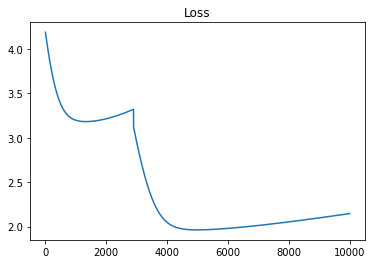

In [9]:
plt.plot(np.linspace(0, NUM_EPOCHS, num=NUM_EPOCHS), losses)
plt.title('Loss')
plt.show()

In [10]:
def extract_dims(space):
    return space[:, 0], space[:, 1], space[:, 2]

from scipy.spatial import ConvexHull
def add_hull(pts, ax, color='r'):
    # adapted from https://stackoverflow.com/a/43347024
    hull = ConvexHull(pts)
    
    # Plot defining corner points
    ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

    # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], color)

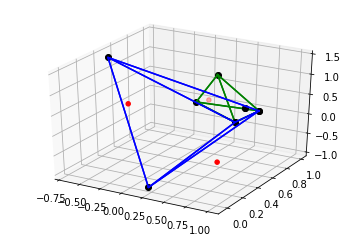

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

initial_x, initial_y, initial_z = extract_dims(initial_space)
ax.scatter3D(xs=initial_x, ys=initial_y, zs=initial_z, c='g')

final_x, final_y, final_z = extract_dims(final_space)
ax.scatter3D(xs=final_x, ys=final_y, zs=final_z, c='b')

data_x, data_y, data_z = extract_dims(train_data)
ax.scatter3D(xs=data_x, ys=data_y, zs=data_z, c='r')

add_hull(initial_space, ax, color='g')
add_hull(final_space, ax, color='b')

# Blue: final space
# Green: initial space
# Red: data points